# Baseline Models

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, RocCurveDisplay, roc_curve
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.pipeline import Pipeline

In [22]:
data = pd.read_csv('../data/train_test_set.csv')

In [23]:
data = data.drop(columns = ['cik', 'sic', 'sic_description', 'filedate', 'accession_num',
       'primary_doc', 'filelink', 'item_1A', 'item_2', 'item_7'])
data = pd.get_dummies(data, columns = ['main_industry', 'year'])

In [24]:
X_train = data[data['train'] == 1].drop(columns=['bank_status'])
y_train = data[data['train'] == 1]['bank_status']
X_test = data[data['train'] == 0].drop(columns=['bank_status'])
y_test = data[data['train'] == 0]['bank_status']

In [25]:
# Standardization
scaler = StandardScaler().fit(X_train.iloc[:, 0:23])
scaled_terms_train = pd.DataFrame(scaler.transform(X_train.iloc[:, 0:23]), columns = X_train.columns[0:23])
X_train_scaled = pd.concat([scaled_terms_train, X_train.iloc[:,23:].reset_index(drop = True)], axis = 1)
scaled_terms_test = pd.DataFrame(scaler.transform(X_test.iloc[:, 0:23]), columns = X_test.columns[0:23])
X_test_scaled = pd.concat([scaled_terms_test, X_test.iloc[:,23:].reset_index(drop = True)], axis = 1)

In [26]:
def measure(clf):
    y_pred_test = clf.predict(X_test_scaled)
    y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
    y_pred_train = clf.predict(X_train_scaled)
    y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

    print(classification_report(y_train, y_pred_train))
    print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
    print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

    print(classification_report(y_test, y_pred_test))
    print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
    print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

# 1. Logistic Regression

## 1.1. vanilla

In [27]:
vlr = LogisticRegression(max_iter = 1000, fit_intercept = False)
vlr.fit(X_train_scaled, y_train)
measure(vlr)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7025
           1       0.00      0.00      0.00        40

    accuracy                           0.99      7065
   macro avg       0.50      0.50      0.50      7065
weighted avg       0.99      0.99      0.99      7065

Train Auc_roc: 0.9000871886120997
Train average precision: 0.12166393014014307
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2330
           1       0.07      0.62      0.13        26

    accuracy                           0.91      2356
   macro avg       0.53      0.76      0.54      2356
weighted avg       0.99      0.91      0.94      2356

Test auc_roc: 0.897160779135028
Test average precision: 0.07554381043239894


/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 1.2. Weighted data

In [28]:
wlr = LogisticRegression(max_iter = 1000, fit_intercept = False, class_weight='balanced')
wlr.fit(X_train_scaled, y_train)
measure(wlr)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      7025
           1       0.03      0.95      0.07        40

    accuracy                           0.85      7065
   macro avg       0.52      0.90      0.49      7065
weighted avg       0.99      0.85      0.91      7065

Train Auc_roc: 0.9340231316725978
Train average precision: 0.051402261898943404
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      2330
           1       0.02      1.00      0.04        26

    accuracy                           0.40      2356
   macro avg       0.51      0.70      0.30      2356
weighted avg       0.99      0.40      0.56      2356

Test auc_roc: 0.8870749422251568
Test average precision: 0.06812607959594369


## 1.3. SMOTE + Logistic Regression

In [29]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
smote_lr = Pipeline(steps = steps)
smote_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(fit_intercept=False, max_iter=1000))])

In [30]:
measure(smote_lr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7025
           1       0.07      0.42      0.12        40

    accuracy                           0.96      7065
   macro avg       0.53      0.70      0.55      7065
weighted avg       0.99      0.96      0.98      7065

Train Auc_roc: 0.8949697508896798
Train average precision: 0.08025958552286513
              precision    recall  f1-score   support

           0       1.00      0.01      0.03      2330
           1       0.01      1.00      0.02        26

    accuracy                           0.03      2356
   macro avg       0.51      0.51      0.03      2356
weighted avg       0.99      0.03      0.03      2356

Test auc_roc: 0.8183228788379002
Test average precision: 0.057578430278492236


# 2. Decision Tree

In [31]:
parameters = {
    'max_depth': [10, 15, 20, 25, 30], 
    'min_samples_leaf': [5, 10, 20, 30], 
    'max_features': ['sqrt', 'log2'], 
    'ccp_alpha': [0.01, 0.001, 0.0001, 0.00001]
}
vanilla_tree = GridSearchCV(
            estimator = tree.DecisionTreeClassifier(random_state = 42),
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
vanilla_tree.fit(X_train_scaled, y_train)

grid_search = GridSearchCV(
            estimator = tree.DecisionTreeClassifier(class_weight = 'balanced', random_state = 42),
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters for vanilla tree:", vanilla_tree.best_params_)
print("Best parameters:", grid_search.best_params_)

Best parameters for vanilla tree: {'ccp_alpha': 0.0001, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10}
Best parameters: {'ccp_alpha': 0.001, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 20}


## 2.1. vanilla tree

In [32]:
measure(vanilla_tree)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7025
           1       0.00      0.00      0.00        40

    accuracy                           0.99      7065
   macro avg       0.50      0.50      0.50      7065
weighted avg       0.99      0.99      0.99      7065

Train Auc_roc: 0.9388416370106762
Train average precision: 0.2015877356835727
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2330
           1       0.00      0.00      0.00        26

    accuracy                           0.99      2356
   macro avg       0.49      0.50      0.50      2356
weighted avg       0.98      0.99      0.98      2356

Test auc_roc: 0.8114394189501486
Test average precision: 0.0609664844193817


/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haodon

## 2.2. weighted data tree

In [33]:
measure(grid_search)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      7025
           1       0.12      1.00      0.22        40

    accuracy                           0.96      7065
   macro avg       0.56      0.98      0.60      7065
weighted avg       1.00      0.96      0.98      7065

Train Auc_roc: 0.9877313167259787
Train average precision: 0.20098033803293833
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2330
           1       0.06      0.23      0.09        26

    accuracy                           0.95      2356
   macro avg       0.52      0.59      0.53      2356
weighted avg       0.98      0.95      0.96      2356

Test auc_roc: 0.5976724991746452
Test average precision: 0.046034751892137286


## 2.3. SMOTE + Decision Tree

In [34]:
model = DecisionTreeClassifier(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__max_depth': [5, 10, 15], 
    'model__min_samples_leaf': [40, 50, 60], 
    'model__max_features': ['log2'], 
    'model__ccp_alpha': [0.0001, 0.00001, 0.000001]
}
smote_tree = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
smote_tree.fit(X_train_scaled, y_train)
print("Best parameters:", smote_tree.best_params_)
print("Best score:", smote_tree.best_score_)

Best parameters: {'model__ccp_alpha': 1e-05, 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 60}
Best score: 0.0945065845264614


In [35]:
measure(smote_tree)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      7025
           1       0.05      0.93      0.10        40

    accuracy                           0.90      7065
   macro avg       0.53      0.91      0.52      7065
weighted avg       0.99      0.90      0.94      7065

Train Auc_roc: 0.9681832740213523
Train average precision: 0.19327756970094187
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2330
           1       0.06      0.65      0.11        26

    accuracy                           0.89      2356
   macro avg       0.53      0.77      0.53      2356
weighted avg       0.99      0.89      0.93      2356

Test auc_roc: 0.9022036975899639
Test average precision: 0.09928599248308306


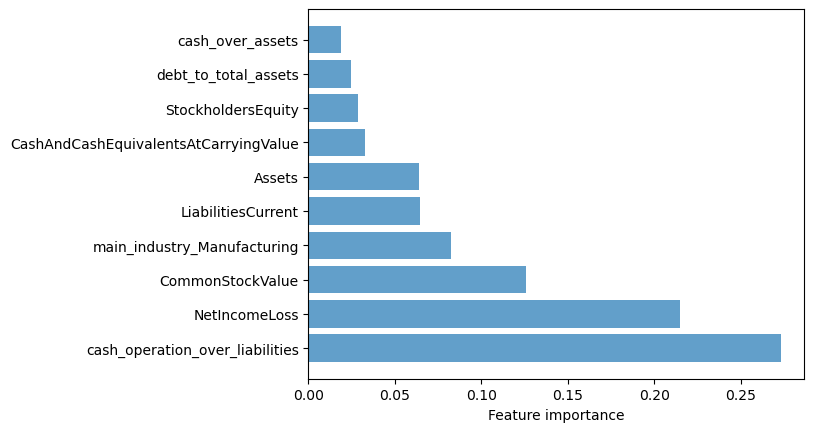

In [36]:
importances = smote_tree.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.barh(range(len(indices)), importances[indices], alpha = 0.7)
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel("Feature importance")
plt.show()

# 3. SVM

In [37]:
param_grid = {
    'C': [10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'] 
}

vsvm = SVC(random_state = 42, probability=True)
vsvm_gs = GridSearchCV(vsvm, param_grid, scoring = 'average_precision', cv = 5)
wsvm = SVC(class_weight = 'balanced', random_state = 42, probability=True)
wsvm_gs = GridSearchCV(wsvm, param_grid, scoring = 'average_precision', cv = 5)

vsvm_gs.fit(X_train_scaled, y_train)
wsvm_gs.fit(X_train_scaled, y_train)

# Output the best parameters and the best score
print("Best parameters for vanilla svm:", vsvm_gs.best_params_)
print("Best parameters for weighted data svm:", wsvm_gs.best_params_)

Best parameters for vanilla svm: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters for weighted data svm: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}


## 3.1 vanilla SVM

In [38]:
measure(vsvm_gs)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7025
           1       1.00      0.20      0.33        40

    accuracy                           1.00      7065
   macro avg       1.00      0.60      0.67      7065
weighted avg       1.00      1.00      0.99      7065

Train Auc_roc: 0.9907562277580071
Train average precision: 0.7783347569230757
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2330
           1       0.00      0.00      0.00        26

    accuracy                           0.99      2356
   macro avg       0.49      0.50      0.50      2356
weighted avg       0.98      0.99      0.98      2356

Test auc_roc: 0.934450313634863
Test average precision: 0.26312861737387055


## 3.2. weighted data SVM

In [39]:
measure(wsvm_gs)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7025
           1       0.75      1.00      0.86        40

    accuracy                           1.00      7065
   macro avg       0.88      1.00      0.93      7065
weighted avg       1.00      1.00      1.00      7065

Train Auc_roc: 0.9994644128113879
Train average precision: 0.8177458762970138
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2330
           1       0.25      0.04      0.07        26

    accuracy                           0.99      2356
   macro avg       0.62      0.52      0.53      2356
weighted avg       0.98      0.99      0.98      2356

Test auc_roc: 0.8256190161769561
Test average precision: 0.13332489166815342


## 3.3. SMOTE + SVM

In [40]:
model = SVC(probability=True, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__C': [10, 100, 1000],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['rbf'] 
}
smote_svm = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
smote_svm.fit(X_train_scaled, y_train)
print("Best parameters:", smote_svm.best_params_)
print("Best score:", smote_svm.best_score_)

Best parameters: {'model__C': 100, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best score: 0.1683234100511951


In [41]:
measure(smote_svm)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7025
           1       0.32      0.57      0.41        40

    accuracy                           0.99      7065
   macro avg       0.66      0.78      0.70      7065
weighted avg       0.99      0.99      0.99      7065

Train Auc_roc: 0.9833434163701067
Train average precision: 0.466430362844432
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2330
           1       0.06      0.04      0.05        26

    accuracy                           0.98      2356
   macro avg       0.53      0.52      0.52      2356
weighted avg       0.98      0.98      0.98      2356

Test auc_roc: 0.8775668537471113
Test average precision: 0.13662298784306423


# 4. Easy Ensemble Classifier

In [42]:
eec = EasyEnsembleClassifier(random_state=42)

In [43]:
eec.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(random_state=42)

In [44]:
measure(eec)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      7025
           1       0.04      1.00      0.08        40

    accuracy                           0.87      7065
   macro avg       0.52      0.94      0.51      7065
weighted avg       0.99      0.87      0.93      7065

Train Auc_roc: 0.9904857651245552
Train average precision: 0.35031490348975963
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      2330
           1       0.07      0.85      0.13        26

    accuracy                           0.88      2356
   macro avg       0.53      0.86      0.53      2356
weighted avg       0.99      0.88      0.92      2356

Test auc_roc: 0.952641135688346
Test average precision: 0.2868326521139267
